In [1]:
import os
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy.interpolate import interp2d
from scipy.signal import find_peaks
from scipy.stats import zscore
import pickle
import os
from scipy.interpolate import griddata
import logging
import sys 
import shutil
from bisect import bisect_left
from ast import literal_eval
import seaborn as sns
from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer
from IPython.display import display
from ipyfilechooser import FileChooser
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings("ignore")

In [32]:
Osc='SWR'
NrSubtype='L1'

path=f"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording_ABmodified/AB_Analysis/Osc_2024_09_12_16_08_44_AH_SWRctx/{Osc}_CaPSTH_CoupledS1Baseline_BlackLinesOK.pkl"
with open(path, 'rb') as file:
    dict_All_ActivityCa_SPDLS1_Baseline=pickle.load(file)
path=f"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording_ABmodified/AB_Analysis/Osc_2024_09_12_16_08_44_AH_SWRctx/{Osc}_CaPSTH_CoupledPFCBaseline_BlackLinesOK.pkl"
with open(path, 'rb') as file:
    dict_All_ActivityCa_SPDLPFC_Baseline=pickle.load(file)
path=f"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording_ABmodified/AB_Analysis/Osc_2024_09_12_16_08_44_AH_SWRctx/{Osc}_CaPSTH_CoupledS1PFCBaseline_BlackLinesOK.pkl"
with open(path, 'rb') as file:
    dict_All_ActivityCa_SPDLS1PFC_Baseline=pickle.load(file)

In [33]:
nr='ThreeColDotsOK41'
nr='RedLinesOK4'
nr='ThreeColDotsOK335'
nr='ThreeColDotsOK1346'
nr='BlackLinesOK0'


In [36]:
dict_All_ActivityCa_SPDLS1_Baseline.keys()

dict_keys(['BlackLinesOK3', 'BlackLinesOK5', 'BlackLinesOK1', 'BlackLinesOK0', 'BlackLinesOK4', 'BlackLinesOK2', 'BlackLinesOK9', 'BlackLinesOK7', 'BlackLinesOK11', 'BlackLinesOK15', 'BlackLinesOK8', 'BlackLinesOK16', 'BlackLinesOK17', 'BlackLinesOK10', 'BlackLinesOK6', 'BlackLinesOK12', 'BlackLinesOK14', 'BlackLinesOK18'])

In [41]:
data=dict_All_ActivityCa_SPDLS1_Baseline[nr]
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
data1=data[:, data.shape[1] // 10 *4  : data.shape[1] // 10 * 6]

In [45]:
data.shape

(34, 120)

In [44]:
data1.shape

(34, 24)

In [40]:
data1=data.iloc[:, data.shape[1] // 10 *4  : data.shape[1] // 10 * 6]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [50]:
mean_baseline

NameError: name 'mean_baseline' is not defined

ValueError: operands could not be broadcast together with shapes (34,24) (34,) 

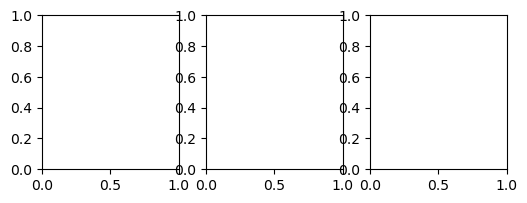

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def process_and_plot(data, ax, vmin=0, vmax=1):
    #data1=data.iloc[:, data.shape[1] // 10 *4  : data.shape[1] // 10 * 6]
    data1=data[:, data.shape[1] // 10 *4  : data.shape[1] // 10 * 6]
    n_cols = np.shape(data1)[1] // 4  # Floor division to get the number of columns in 1/4th
    baseline_columns = data1[:, :n_cols]  # Select the first 'n_cols' columns
    mean_baseline = np.nanmean(baseline_columns,axis=1)
    data2 = data1-mean_baseline
    sns.heatmap(data2, ax=ax, cmap='viridis', xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)
plt.close()

fig, axes = plt.subplots(1, 3, figsize=(6, 2))

# Check if subplots are correctly created
process_and_plot(dict_All_ActivityCa_SPDLS1_Baseline[nr], axes[0])
process_and_plot(dict_All_ActivityCa_SPDLPFC_Baseline[nr], axes[1])
process_and_plot(dict_All_ActivityCa_SPDLS1PFC_Baseline[nr], axes[2])

plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract_{nr}_heatmap_Spdl_Catraces.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()


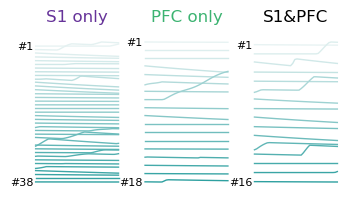

In [149]:
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(4, 2))  # Increased figure size for better readability

cmap = sns.light_palette("#008B8B", as_cmap=True)
#cmap = sns.light_palette("black", as_cmap=True)

def plot_lines(data, ax, title, xlabel=None, title_color='black', cmap=cmap):
    data1=data.iloc[:, data.shape[1] // 10 *4  : data.shape[1] // 10 * 6]
    n_cols = len(data1.columns) // 4  # Floor division to get the number of columns in 1/4th
    baseline_columns = data1.iloc[:, :n_cols]  # Select the first 'n_cols' columns
    mean_baseline = np.nanmean(baseline_columns,axis=1)
    data2 = data1.sub(mean_baseline, axis=0)
    data2=np.array(data2)
    num_lines = data2.shape[0]
    colors = cmap(np.linspace(0., .8, num_lines))
    ax.text(-1,0, f'#1', color='black', ha='right', va='center', fontsize=8) 
    # Plot each line with a label
    for i in range(num_lines):
        line_data = data2[i] - i * 1.5
        ax.plot(0, min(line_data), line_data, color=colors[i], linewidth=1)
    ax.text(-1, min(line_data), f'#{i+1}', color='black', ha='right', va='center', fontsize=8) 
    ax.set_title(title, fontsize=12, color=title_color, pad=10)  # Added padding for the title
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=2, fontsize=10)    
    ax.axis('off')  # Hide axis lines and labels

data = dict_All_ActivityCa_SPDLS1_Baseline[nr][::] *2  # [::2] Taking every other row
plot_lines(data, axes[0], 'S1 only', title_color='rebeccapurple')
data = dict_All_ActivityCa_SPDLPFC_Baseline[nr]*2
plot_lines(data, axes[1], 'PFC only', title_color='mediumseagreen')
data = dict_All_ActivityCa_SPDLS1PFC_Baseline[nr]*2
plot_lines(data, axes[2], 'S1&PFC')

output_path = f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract_line_{nr}_Spdl_CatracesLag.svg'
plt.savefig(output_path, format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

# Show the plot
plt.show()


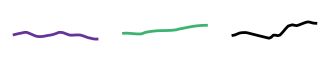

In [150]:
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(4, .5))  # Increased figure size for better readability

#cmap = sns.light_palette("#008B8B", as_cmap=True)
cmap = sns.light_palette("black", as_cmap=True)

def plot_lines(data, ax,title_color='black', cmap=cmap):
    data1=data.iloc[:, data.shape[1] // 10 *4  : data.shape[1] // 10 * 6]
    n_cols = len(data1.columns) // 4  # Floor division to get the number of columns in 1/4th
    baseline_columns = data1.iloc[:, :n_cols]  # Select the first 'n_cols' columns
    mean_baseline = np.nanmean(baseline_columns,axis=1)
    data2 = data1.sub(mean_baseline, axis=0)
    ax.plot(np.nanmean(data2, axis=0), color=title_color, linewidth=2)
    ax.set_ylim(-.6, 1)    
    ax.axis('off')  # Hide axis lines and labels

data = dict_All_ActivityCa_SPDLS1_Baseline[nr]*5 # [::2] Taking every other row
plot_lines(data, axes[0],  title_color='rebeccapurple')
data = dict_All_ActivityCa_SPDLPFC_Baseline[nr]*5
plot_lines(data, axes[1], title_color='mediumseagreen')
data = dict_All_ActivityCa_SPDLS1PFC_Baseline[nr]*5
plot_lines(data, axes[2])

output_path = f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract_AVG_{nr}_Spdl_CatracesLag.svg'
plt.savefig(output_path, format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

# Show the plot
plt.show()


In [137]:
Nr='L1'
#Nr='L2&3'

if Nr=='L1':
    path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_Osc_2024-09-06_12_10_05_AH_1secPSTHpkl/L1_Spdl_Global.xlsx"
    dfa=pd.read_excel(path)

    path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-09-03_11_00_49_AB_wRealTS/Baseline/All/L1_VigSt_nAUC.xlsx"
    dfi=pd.read_excel(path)
else:
    path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_Osc_2024-09-06_12_10_05_AH_1secPSTHpkl/L2&3_Spdl_Global.xlsx"
    dfa=pd.read_excel(path)

    path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-09-03_11_00_49_AB_wRealTS/Baseline/All/L2&3_VigSt_nAUC.xlsx"
    dfi=pd.read_excel(path)


dfii = dfi.pivot_table(index='Unit_ID', values='NREM', fill_value=0)
dfii2 = dfi.pivot_table(index='Unit_ID', values='RatioNREM_REM', fill_value=0)
dfAll=pd.concat([dfii,dfii2], axis=1, ignore_index=False)


dfd = dfa[dfa['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'S1'] 
dfd['NormAUCBeforeS1']=dfd['AUC_calciumBefore']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCBeforeS1', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd['NormAUCDuringS1']=dfd['AUC_calciumDuring']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCDuringS1', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)



dfd = dfa[dfa['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'PFC'] 
dfd['NormAUCBeforePFC']=dfd['AUC_calciumBefore']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCBeforePFC', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd['NormAUCDuringPFC']=dfd['AUC_calciumDuring']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCDuringPFC', aggfunc='mean', fill_value=0)

dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Global'] 
dfd['NormAUCBeforeGBL']=dfd['AUC_calciumBefore']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCBeforeGBL', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd['NormAUCDuringGBL']=dfd['AUC_calciumDuring']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCDuringGBL', aggfunc='mean', fill_value=0)

dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfAll['S1diff']=dfAll['NormAUCDuringS1']-dfAll['NormAUCBeforeS1']
dfAll['PFCdiff']=dfAll['NormAUCDuringPFC']-dfAll['NormAUCBeforePFC']
dfAll['GBLdiff']=dfAll['NormAUCDuringGBL']-dfAll['NormAUCBeforeGBL']

dfAll = dfAll.dropna(subset=['RatioNREM_REM'])

df_cleaned=dfAll.copy()
df_cleaned = df_cleaned.dropna(subset=['S1diff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('ACTIVE')

print('S1')
print(sum(dfAllnrem['S1diff']>0)/len(df_cleaned)*100)
print(sum(dfAllns['S1diff']>0)/len(df_cleaned)*100)
print(sum(dfAllrem['S1diff']>0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['PFCdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('PFC')
print(sum(dfAllnrem['PFCdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllns['PFCdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllrem['PFCdiff']>0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['GBLdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('GBL')
print(sum(dfAllnrem['GBLdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllns['GBLdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllrem['GBLdiff']>0)/len(df_cleaned)*100)

if Nr=='L1':
    dfAll.to_excel(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/L1_Act_Spdl.xlsx')
else:
    dfAll.to_excel(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/L2&3_Act_Spdl.xlsx')


print('INACTIVE')

print('S1')
print(sum(dfAllnrem['S1diff']<0)/len(df_cleaned)*100)
print(sum(dfAllns['S1diff']<0)/len(df_cleaned)*100)
print(sum(dfAllrem['S1diff']<0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['PFCdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('PFC')
print(sum(dfAllnrem['PFCdiff']<0)/len(df_cleaned)*100)
print(sum(dfAllns['PFCdiff']<0)/len(df_cleaned)*100)
print(sum(dfAllrem['PFCdiff']<0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['GBLdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('GBL')
print(sum(dfAllnrem['GBLdiff']<0)/len(df_cleaned)*100)
print(sum(dfAllns['GBLdiff']<0)/len(df_cleaned)*100)
print(sum(dfAllrem['GBLdiff']<0)/len(df_cleaned)*100)


ACTIVE
S1
10.714285714285714
5.357142857142857
14.285714285714285
PFC
11.570247933884298
4.958677685950414
14.87603305785124
GBL
6.25
7.142857142857142
16.964285714285715
INACTIVE
S1
16.964285714285715
8.928571428571429
34.82142857142857
PFC
22.31404958677686
8.264462809917356
25.6198347107438
GBL
21.428571428571427
6.25
24.107142857142858


% Before= 3.3
% During= 3.34
% After= 3.46
% Response= 10.09


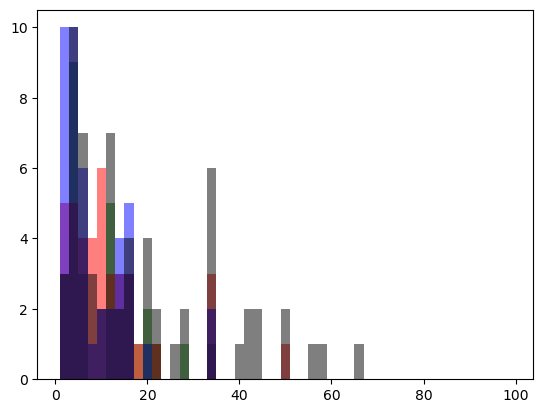

In [138]:
dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Global'] 

dfd['SpikeActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dfd['CalciumActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dff = dfd.pivot_table(index='Unit_ID', columns=[dfd['SpikeActivityPreference']], values='SpikeActivityPreference', aggfunc='count', fill_value=0)
dff['Total']=dff.sum(axis=1)

dff['%Before']=np.round(dff['Before']/dff['Total']*100,2)
dff['%During']=np.round(dff['During']/dff['Total']*100,2)
dff['%After']=np.round(dff['After']/dff['Total']*100,2)
dff['%Response']=np.round((dff['Before']+dff['During']+dff['After'])/dff['Total']*100,2)

bin_edges = range(1,100,2)
plt.close()
plt.hist(dff['%Before'], bins=bin_edges,  alpha=0.5, color='green')
plt.hist(dff['%During'], bins=bin_edges,  alpha=0.5, color='red')
plt.hist(dff['%After'], bins=bin_edges,  alpha=0.5, color='blue')
plt.hist(dff['%Response'], bins=bin_edges,  alpha=0.5, color='black')
print('% Before=',round(np.mean(dff['%Before']),2))
print('% During=',round(np.mean(dff['%During']),2))
print('% After=',round(np.mean(dff['%After']),2))
print('% Response=',round(np.mean(dff['%Response']),2))

plt.show()


In [140]:
dff[dff['%During']>15]

SpikeActivityPreference,After,Before,During,NoPref,Total,%Before,%During,%After,%Response
Unit_ID,,,,,,,,,
BlackLinesOK8,2,2,3,9,16,12.50,18.75,12.50,43.75
BlueLinesOK14,0,0,2,7,9,0.00,22.22,0.00,22.22
BlueLinesOK27,1,0,1,4,6,0.00,16.67,16.67,33.33
BlueLinesOK41,0,1,3,2,6,16.67,50.00,0.00,66.67
BlueLinesOK44,0,0,2,4,6,0.00,33.33,0.00,33.33
BlueLinesOK46,1,0,1,4,6,0.00,16.67,16.67,33.33
BlueLinesOK47,1,1,1,3,6,16.67,16.67,16.67,50.00
RedLinesOK61,0,2,3,4,9,22.22,33.33,0.00,55.56
RedLinesOK66,0,1,3,5,9,11.11,33.33,0.00,44.44


% Before= 4.9
% During= 5.17
% After= 5.74
% Response= 15.81


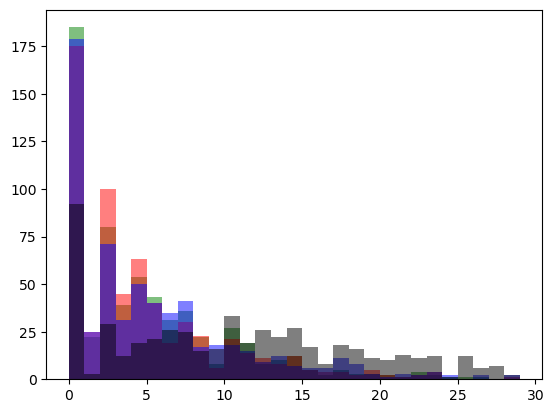

In [121]:
dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'S1'] 

dfd['SpikeActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dfd['CalciumActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dff = dfd.pivot_table(index='Unit_ID', columns=[dfd['SpikeActivityPreference']], values='SpikeActivityPreference', aggfunc='count', fill_value=0)
dff['Total']=dff.sum(axis=1)

dff['%Before']=np.round(dff['Before']/dff['Total']*100,2)
dff['%During']=np.round(dff['During']/dff['Total']*100,2)
dff['%After']=np.round(dff['After']/dff['Total']*100,2)
dff['%Response']=np.round((dff['Before']+dff['During']+dff['After'])/dff['Total']*100,2)

dff

bin_edges = range(0,30,1)
plt.close()
plt.hist(dff['%Before'], bins=bin_edges,  alpha=0.5, color='green')
plt.hist(dff['%During'], bins=bin_edges,  alpha=0.5, color='red')
plt.hist(dff['%After'], bins=bin_edges,  alpha=0.5, color='blue')
plt.hist(dff['%Response'], bins=bin_edges,  alpha=0.5, color='black')

print('% Before=',round(np.mean(dff['%Before']),2))
print('% During=',round(np.mean(dff['%During']),2))
print('% After=',round(np.mean(dff['%After']),2))
print('% Response=',round(np.mean(dff['%Response']),2))

plt.show()

In [42]:
dff[dff['%During']>20]

SpikeActivityPreference,After,Before,During,NoPref,Total,%Before,%During,%After,%Response
Unit_ID,,,,,,,,,
Purple511,0,0,1,0,1,0.00,100.00,0.00,100.00
Purple61,16,13,20,36,85,15.29,23.53,18.82,57.65
Purple644,0,0,2,1,3,0.00,66.67,0.00,66.67
ThreeBlueCrossesOK23,3,2,2,2,9,22.22,22.22,33.33,77.78
ThreeColDotsOK112,20,17,20,31,88,19.32,22.73,22.73,64.77
ThreeColDotsOK1346,8,4,11,24,47,8.51,23.40,17.02,48.94
ThreeColDotsOK227,3,3,7,14,27,11.11,25.93,11.11,48.15
ThreeColDotsOK642,7,2,4,4,17,11.76,23.53,41.18,76.47
ThreeColDotsOK683,4,4,4,5,17,23.53,23.53,23.53,70.59


In [ ]:
dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'PFC'] 

dfd['SpikeActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dfd['CalciumActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dff = dfd.pivot_table(index='Unit_ID', columns=[dfd['SpikeActivityPreference']], values='SpikeActivityPreference', aggfunc='count', fill_value=0)
dff['Total']=dff.sum(axis=1)

dff['%Before']=np.round(dff['Before']/dff['Total']*100,2)
dff['%During']=np.round(dff['During']/dff['Total']*100,2)
dff['%After']=np.round(dff['After']/dff['Total']*100,2)
dff['%Response']=np.round((dff['Before']+dff['During']+dff['After'])/dff['Total']*100,2)

dff

bin_edges = range(1,100,2)
plt.close()
plt.hist(dff['%Before'], bins=bin_edges,  alpha=0.5, color='green')
plt.hist(dff['%During'], bins=bin_edges,  alpha=0.5, color='red')
plt.hist(dff['%After'], bins=bin_edges,  alpha=0.5, color='blue')
plt.hist(dff['%Response'], bins=bin_edges,  alpha=0.5, color='black')

print('% Before=',round(np.mean(dff['%Before']),2))
print('% During=',round(np.mean(dff['%During']),2))
print('% After=',round(np.mean(dff['%After']),2))
print('% Response=',round(np.mean(dff['%Response']),2))
plt.show()

In [ ]:
dff[dff['%During']>20]